In [186]:
import pandas as pd 
import numpy as np 
import umap

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as tfidf
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as accuracy 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from PIL import Image
from wordcloud import WordCloud
from textwrap import wrap

import sys; sys.path.insert(0, '../') #adds all the code we've written in src
from preprocessing import *

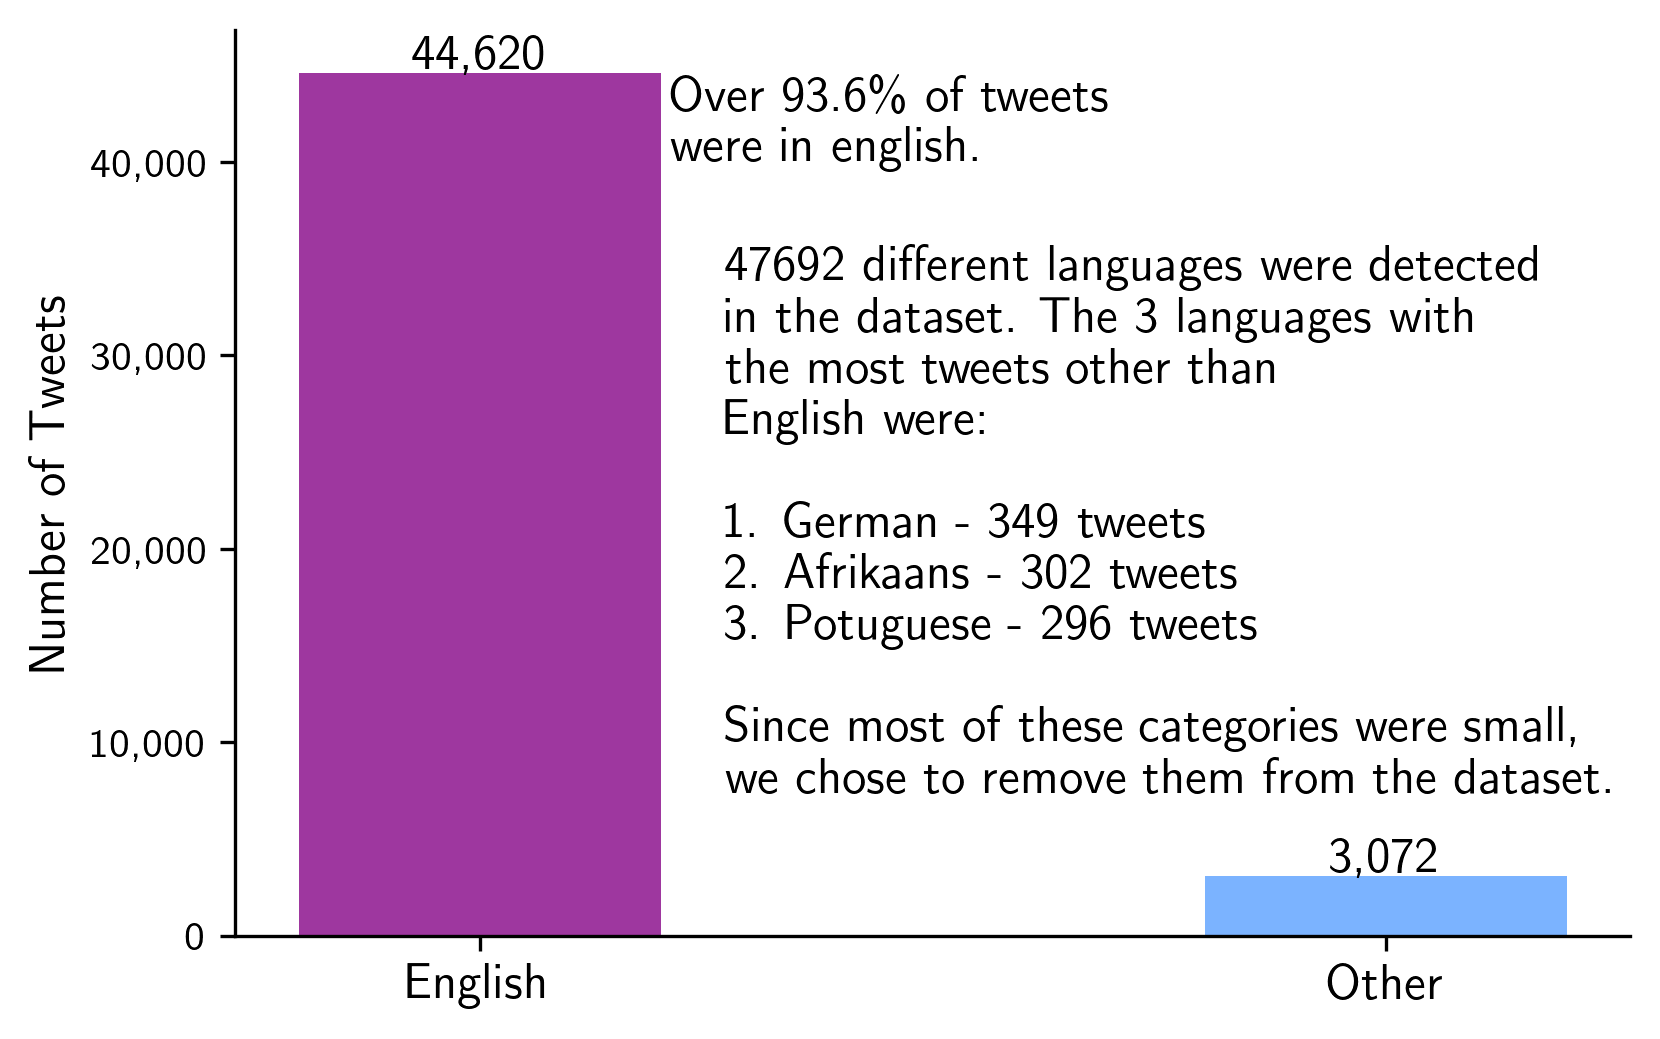

In [11]:
lang_df = pd.read_csv("../../cyberbullying_tweets/tweets_with_lang.csv")

plt.rcParams["figure.figsize"] = [6,4]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True #change to true for final

labels = ["English", "Other"]
xs = [0, 1]
values = [44620, len(lang_df) - 44620] 

fig, ax = plt.subplots()

colors = ["#9e379f", "#7bb3ff"]
bars = ax.bar(xs, values, width = 0.4, color = colors)

ax.set_xticks(xs)
ax.set_xticklabels(labels, fontsize = 12)
ax.spines[["top", "right"]].set_visible(False)
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ',')))

#title
top, bottom = ax.get_ylim()[1], ax.get_ylim()[0]
right, left = ax.get_xlim()[1], ax.get_xlim()[0]
center = sum(ax.get_xlim())/2

# ax.text(center, top + 200, "Distribution of Language of Tweets", va = "bottom", fontsize = 14, ha = "center")

#labels 
ax.text(0, values[0] + 200, "44,620", ha = "center", fontsize = 12)
ax.text(1, values[1] + 200, f"{len(lang_df) - 44620:,}", ha = "center", fontsize = 12)

#annotation1 
anno_text1 = f"""Over {44620/len(lang_df)*100:0.1f}\% of tweets\nwere in english.""" 
ax.text(0.21, values[0] - 200, anno_text1, ha = "left", va = "top", fontsize = 12)

#annotation2 
anno_text2 = f"""{len(lang_df)} different languages were detected
in the dataset. The 3 languages with 
the most tweets other than 
English were: 

    \t1. German - 349 tweets
    \t2. Afrikaans - 302 tweets
    \t3. Potuguese - 296 tweets
    
Since most of these categories were small, 
we chose to remove them from the dataset. 
"""

ax.text(0.27, values[0] - 9000, anno_text2, ha = "left", va = "top", fontsize = 12)

ax.set_ylabel("Number of Tweets", fontsize = 12)

plt.savefig("../../plots/lang_bar_plot.png")

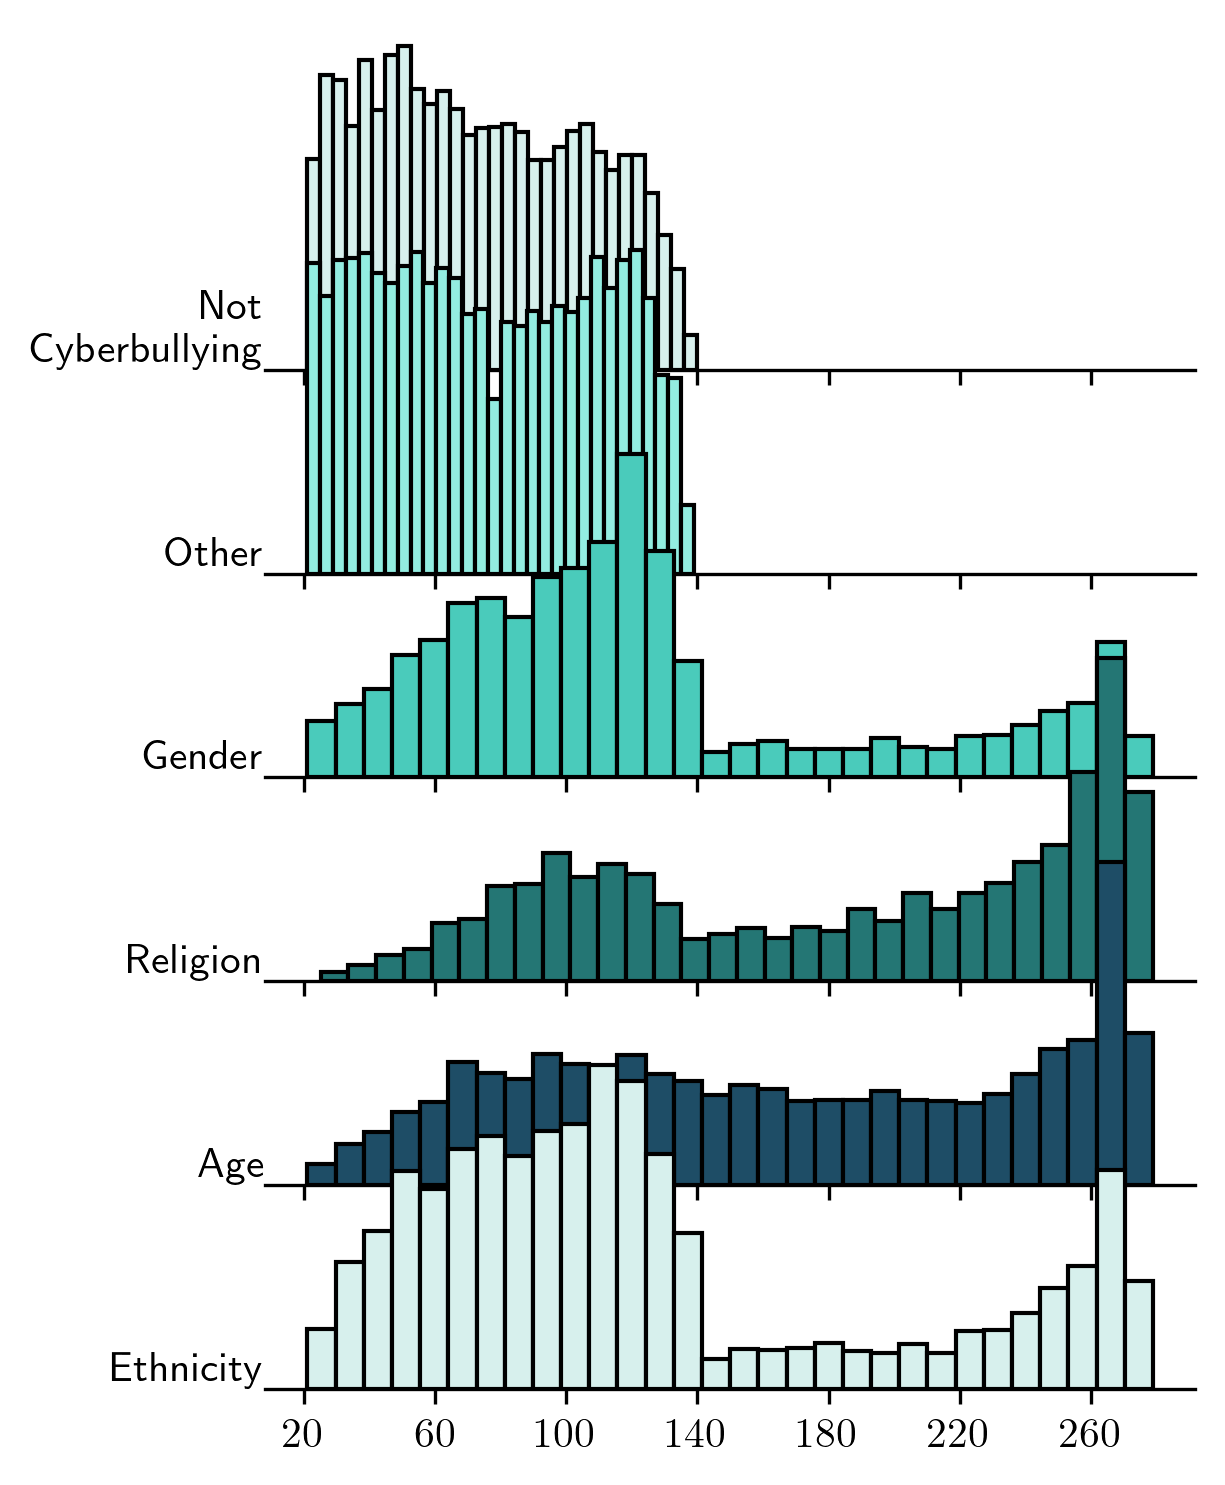

In [79]:
###distribution of length of tweets by category 
df = pd.read_csv("../../cyberbullying_tweets/processed_tweets.csv")
cat_map = {
    "not_cyberbullying": 'Not\nCyberbullying', 
    "other_cyberbullying": 'Other',
    "gender": 'Gender', 
    "religion": 'Religion', 
    "age": 'Age',
    "ethnicity": 'Ethnicity',
}

plt.rcParams["figure.figsize"] = [4,6]
plt.rcParams["figure.dpi"] = 300

fig, axes = plt.subplots(6, 1, sharex = True)

colors = [
    "#d7f0ed",
    "#93ede1",
    "#4acbbb",
    "#247674",
    "#1e4d66", 
    "#d7f0ed"
]

i = 0
for ax, label in zip(axes, cat_map.keys()):
    vals = df[df.cyberbullying_type == label].ascii_length
    ax.hist(vals, bins = 30, density = True, ec = 'black', label = cat_map[label], color = colors[i])
    ax.spines[["left", "right", "top"]].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(8, ax.get_ylim()[0], cat_map[label], rotation = 0, ha = "right", va = "bottom")
    ax.set_facecolor([0,0,0,0])
    
    i += 1
    
axes[-1].set_xticks(np.arange(20, 281, 40))

plt.subplots_adjust(hspace = -0.4)
plt.savefig("../../plots/tweet_length.png", bbox_inches = "tight")

In [85]:
X = df.ascii.to_numpy()
y = df.y.to_numpy()

bow_vectorizer = CountVectorizer(tokenizer=word_tokenize, analyzer = 'word', stop_words=None, ngram_range=(1,1), lowercase=False)
tf_vectorizer = tfidf()

data_bow = bow_vectorizer.fit_transform(X)
data_tfidf = tf_vectorizer.fit_transform(data_bow)

embedding = umap.UMAP(n_components=2, metric='hellinger').fit(data_tfidf)

C:\Users\Ayush\.conda\envs\nlp\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 386 edges.
It has only fully disconnected 20 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


(-1.523106822371483, 20.781048604846)


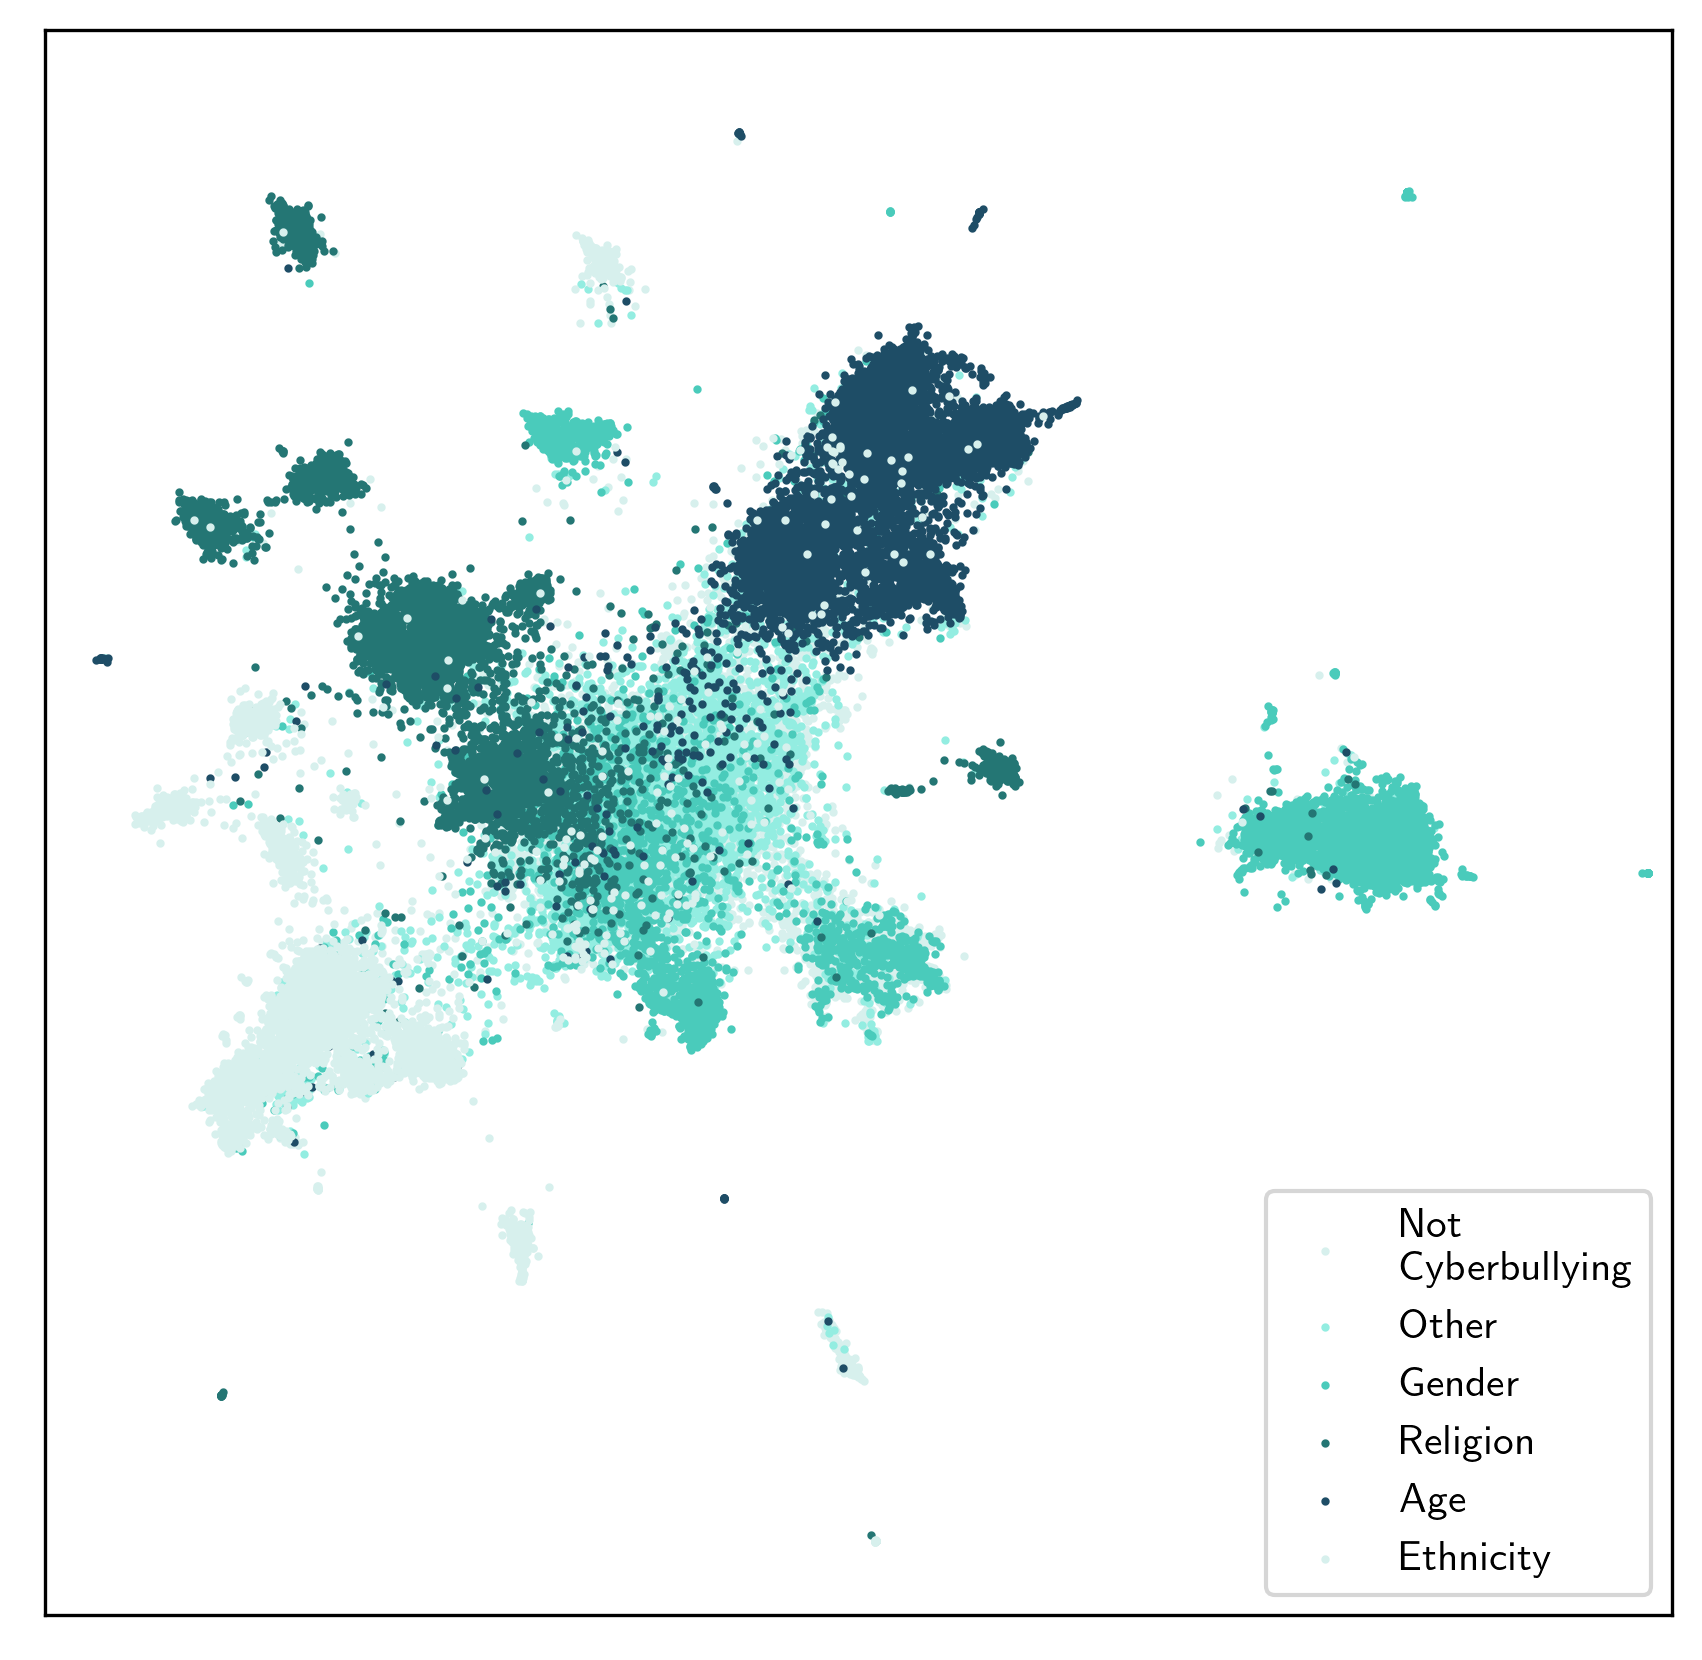

In [133]:
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.dpi"] = 300

for i, cat in enumerate(cat_map.keys()): 
    obs = np.where(df.cyberbullying_type == cat)
    plt.scatter(embedding.embedding_[obs,0], embedding.embedding_[obs,1], s = 1, 
                color = colors[i], label = cat_map[cat])
    
plt.xticks([]) 
plt.yticks([])
print(plt.xlim())
plt.xlim([4, 20])
plt.ylim([-8, 9])
plt.legend(loc='lower right', s)

plt.savefig("../../plots/embedding.png")

In [163]:
mask = np.array(Image.open("Twitter-logo.png"))

def transform_format(val):
    return 225 if val == 0 else return val
    
mask = np.vectorize(transform_format)(mask)

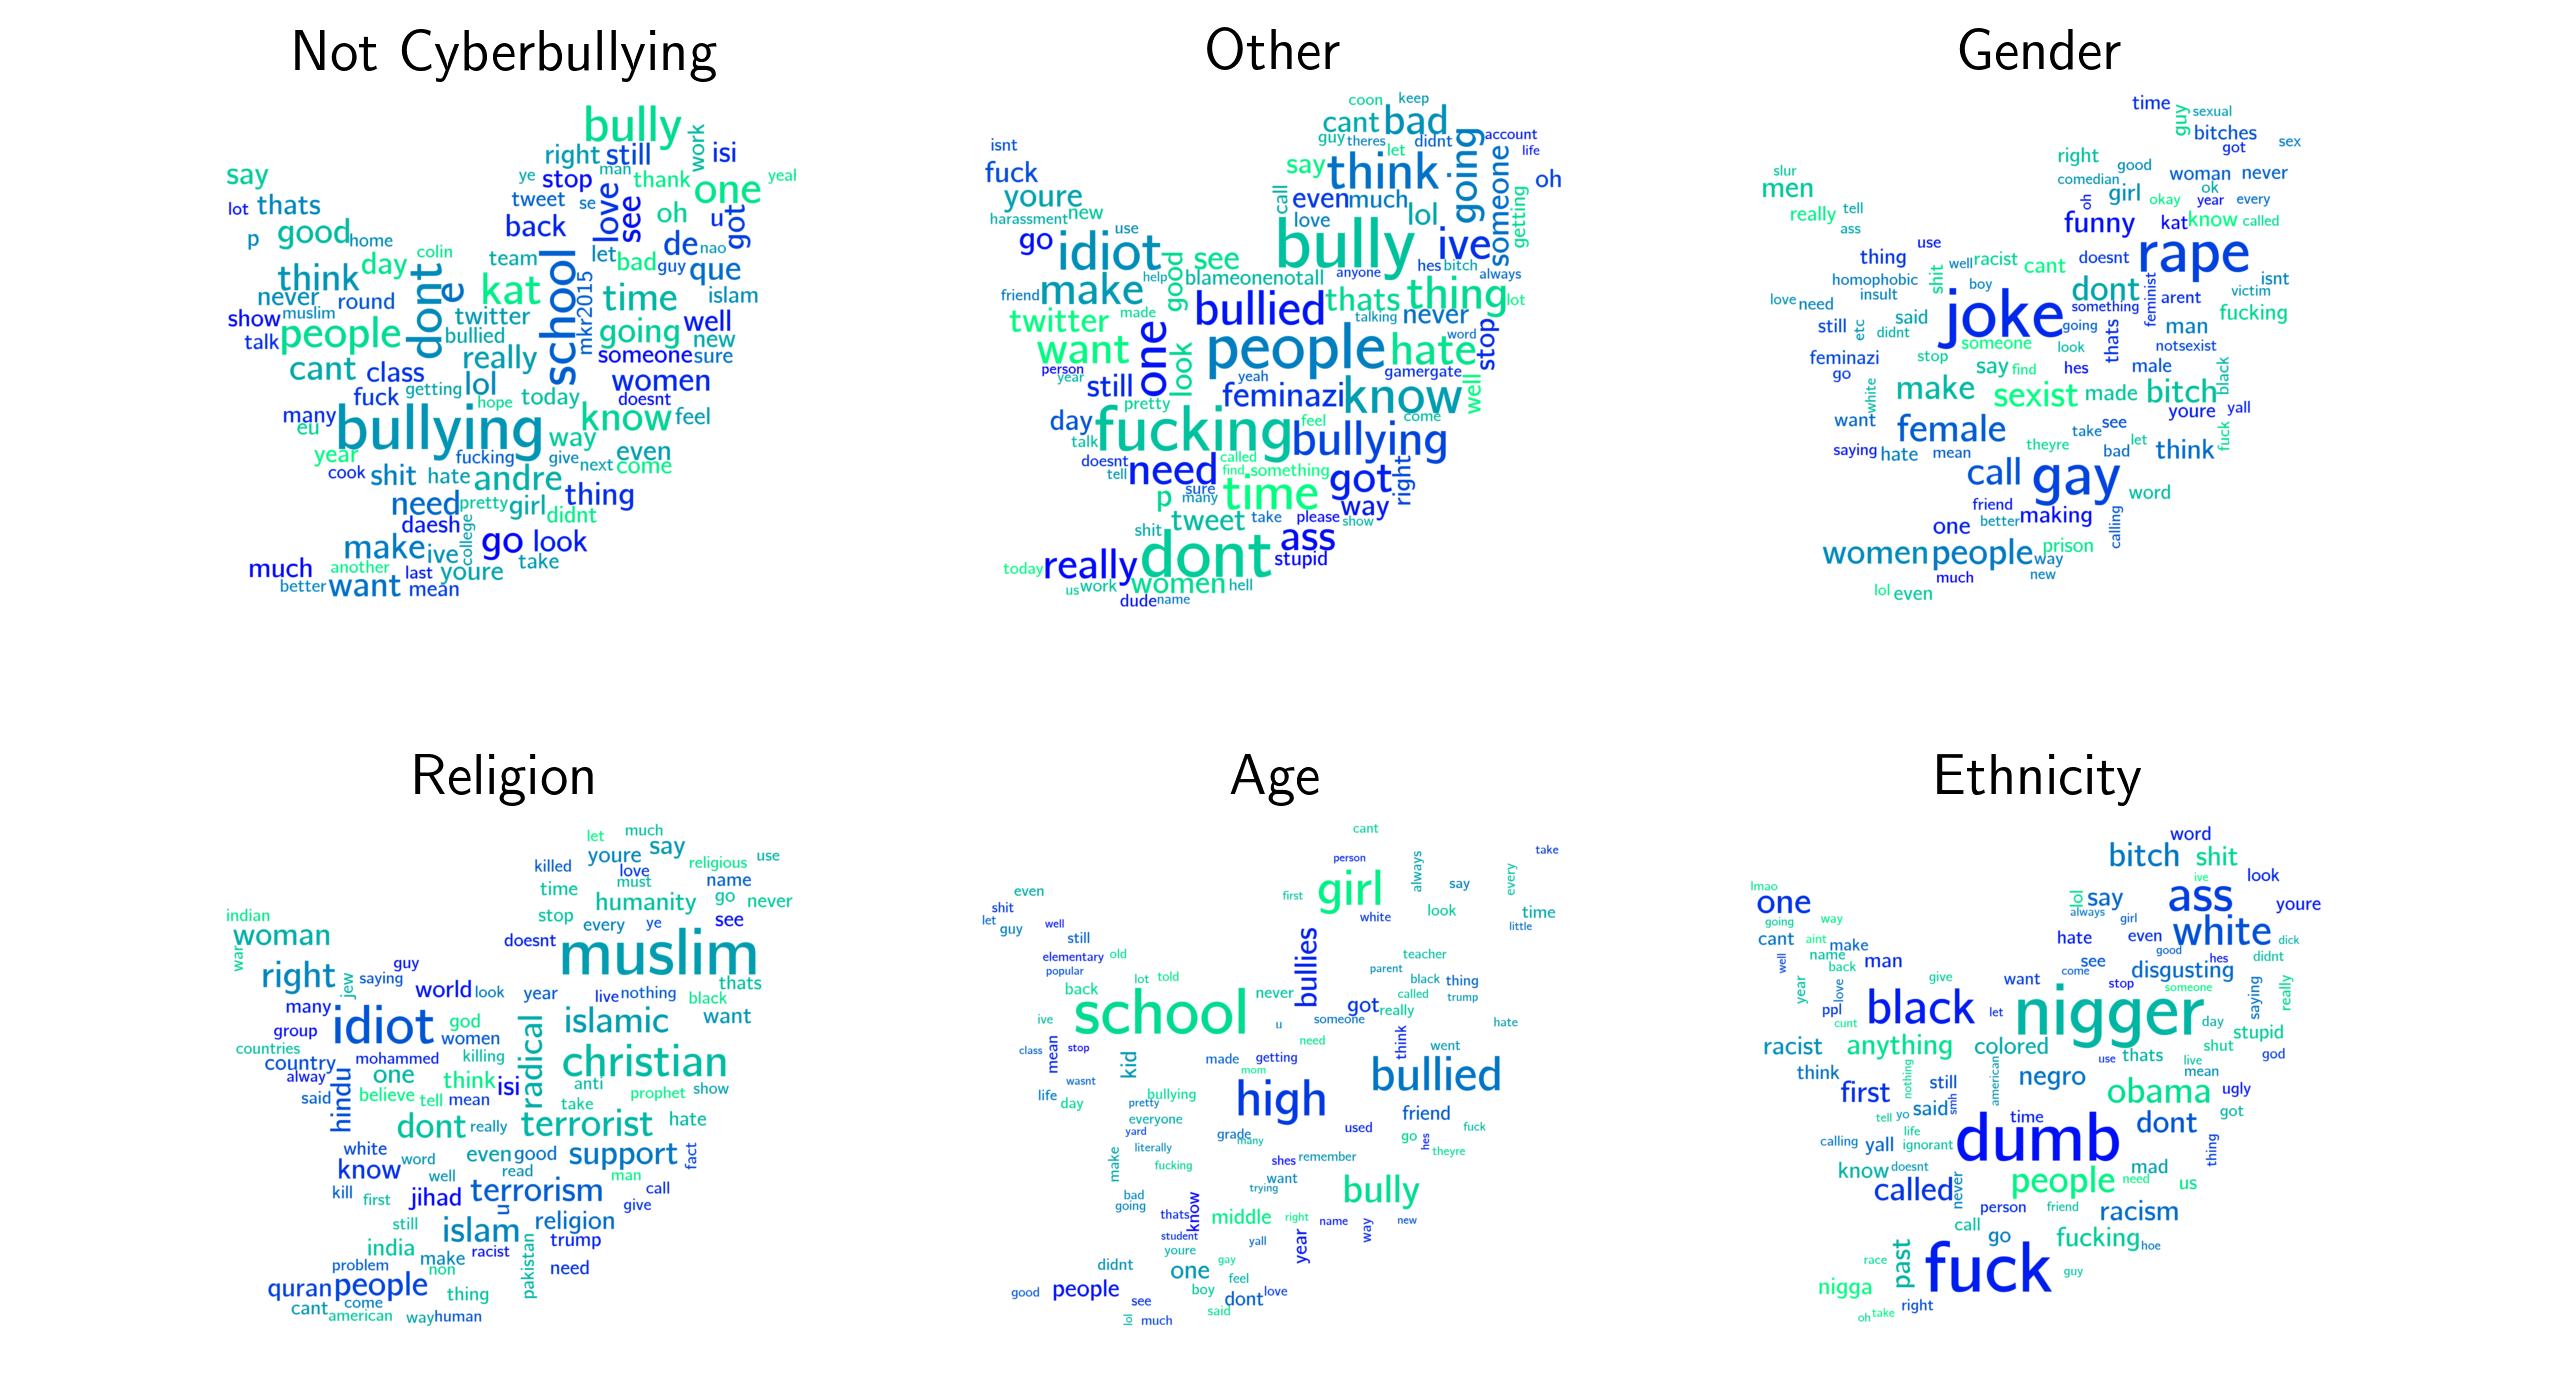

In [173]:
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams["figure.dpi"] = 300

fig, axes = plt.subplots(2, 3)
fig.tight_layout()

cat_map = {
    "not_cyberbullying": 'Not Cyberbullying', 
    "other_cyberbullying": 'Other',
    "gender": 'Gender', 
    "religion": 'Religion', 
    "age": 'Age',
    "ethnicity": 'Ethnicity',
}

font = "../../computer-modern/cmunbsr.ttf"

for label, ax in zip(cat_map.keys(), axes.flatten()): 
    word_list = df[df["cyberbullying_type"] == label]["ascii"]
    text = remove_stopwords(word_list)
    text = text.apply(pd.Series).stack().unique()
    text = " ".join(text)


    wc = WordCloud(collocations = False, background_color = 'white',
                             font_path = font, width = 300, height = 300, colormap = "winter", 
                             max_words = 100, mask=mask).generate(text)

    ax.imshow(wc, interpolation='bilinear')
    ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1], cat_map[label], 
            va = "bottom", ha = "center", fontsize = 14)
    ax.axis("off")

plt.subplots_adjust(wspace = -0.2, hspace = -0.2)
plt.savefig("../../plots/word_clouds.png")

In [179]:
#xlnet results 
xl = pd.read_csv("xlnet_results.csv", index_col = 0)

cat_dict = {}
for i, type in enumerate(df.cyberbullying_type.unique()):
    cat_dict[type] = i 

xl["y"] = xl.true.map(cat_dict)
xl["yhat"] = xl.pred.map(cat_dict)
xl

,true,pred,y,yhat
0,ethnicity,ethnicity,5,5
1,other_cyberbullying,other_cyberbullying,3,3
2,age,age,4,4
3,religion,religion,2,2
4,religion,religion,2,2
...,...,...,...,...
8231,age,age,4,4
8232,other_cyberbullying,other_cyberbullying,3,3
8233,age,age,4,4
8234,age,age,4,4


In [184]:
print(classification_report(xl.y, xl.yhat))
print(f1(xl.y, xl.yhat, average="macro"))
print(accuracy(xl.y, xl.yhat))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1165
           1       0.93      0.86      0.89      1513
           2       0.95      0.97      0.96      1553
           3       0.63      0.69      0.66       967
           4       0.98      0.98      0.98      1548
           5       0.99      0.98      0.98      1490

    accuracy                           0.88      8236
   macro avg       0.86      0.86      0.85      8236
weighted avg       0.88      0.88      0.88      8236

0.8549319498124065
0.8762748907236523


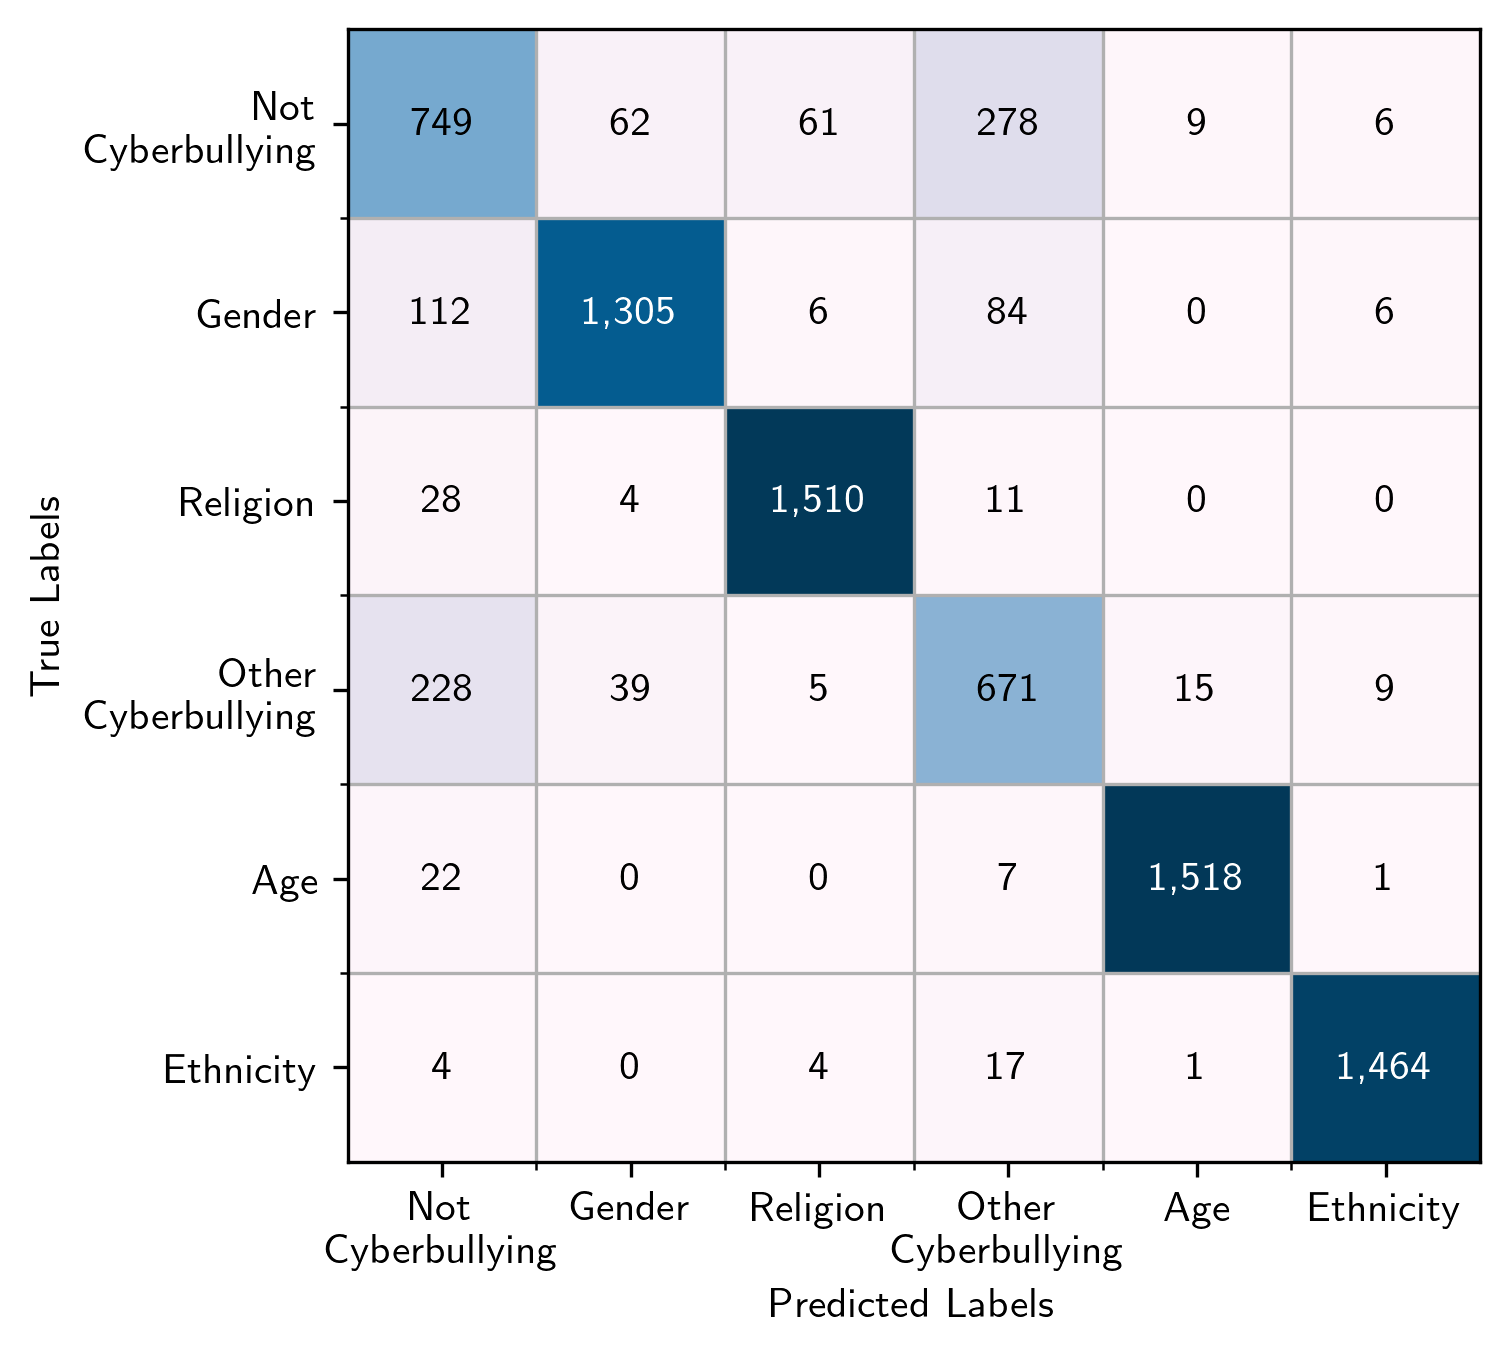

In [219]:
plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["figure.dpi"] = 300

fig, ax = plt.subplots()
conf_mat = confusion_matrix(xl.y, xl.yhat)

ax.matshow(conf_mat, cmap = "PuBu")

ylabels = ["Not Cyberbullying", "Gender", "Religion", "Other Cyberbullying", "Age", "Ethnicity"]
xlabels = ["Not\nCyberbullying", "Gender", "Religion", "Other\nCyberbullying", "Age", "Ethnicity"]

ax.set_yticks(np.arange(6), xlabels)
ax.set_xticks(np.arange(6), xlabels)

#set minor ticks for grid seperation
ax.set_xticks(np.arange(0.5, 5.5, 1), minor=True)
ax.set_yticks(np.arange(0.5, 5.5, 1), minor=True)

ax.xaxis.set_ticks_position("bottom")

#add in labels for numbers 
for (i, j), z in np.ndenumerate(conf_mat):
    if z > 1300: 
        ax.text(j, i, '{:,}'.format(z), ha='center', va='center', color = "white")
    else: 
        ax.text(j, i, '{:,}'.format(z), ha='center', va='center')

ax.grid(which="minor")
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")

plt.savefig("../../plots/xlnet_confmat.png", bbox_inches = "tight")